In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute, quantum_info

# TODO
* Ensure initial random vector is the same for all optimizers, just to be fair
* Tests
* Write docs and references
* Optimize optimizer parameters, eta's, tolerances, etc.
* Run it once with 1000 iterations, and go for lunch, and hope jupyter doesn't die
* Benchmark execution time for each optimizer
* Find parameters with dwave and compare, perhaps?
* Add a noise model to the simulator and reevaluate results

In [2]:
L = 10
N_QUBITS = 4
CURRENT_LAYER = 0
PHI = quantum_info.random_statevector(2**N_QUBITS)
ITERATIONS = 500 # Iterations for each step in each opimizer. Start with 50 to test. Then increase gradually and go for a (long) coffee

backend = Aer.get_backend("qasm_simulator")

In [3]:
# Unitary 4 Qubit gate with Rz's full entanglement
def even_gate(theta, index, qubits):
    name = "Ue"+str(index)+"("+str(theta)+")"
    u_even = QuantumCircuit(4, name=name)
    u_even.rz(theta,qubits)

    for t in qubits:
        i = t
        for z in range(len(qubits)-t-1):
            u_even.cz(t, i + 1)
            i += 1

    return u_even

# Unitary 4 Qubit gate with Rx's and no entanglement
def odd_gate(theta, index, qubits):
    name = "Uo"+str(index)+"("+str(theta)+")"
    u_odd = QuantumCircuit(4, name=name)
    u_odd.rx(theta, qubits)

    return u_odd

In [4]:
def calculate_random_theta():
    return np.random.uniform(0, 2*np.pi)

In [5]:
def get_random_thetas(layers):
    thetas = []
    for i in range(layers):
        thetas.append(calculate_random_theta())
    return thetas

In [6]:
def get_variational_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    
    qubits = [i for i in range(n_qubits)]
    circuit = QuantumCircuit(n_qubits)
    theta = 0
    for i in range(layers):
        circuit.append(even_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        circuit.append(odd_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        
    return circuit

def run_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    circuit = get_variational_circuit(thetas)
    
    simulator = Aer.get_backend("statevector_simulator")
    job = execute(circuit, backend=simulator, shots=1024)
    result = job.result()
    
    return result.get_statevector(circuit)


In [7]:
def objective_function(thetas):
    psi_theta = run_circuit(thetas)
    cost = np.linalg.norm(psi_theta - PHI.data)
    return cost

In [8]:
# Test Circuit
thetas = get_random_thetas(L*2)
CURRENT_LAYER = 3
circuit = get_variational_circuit(thetas)
circuit.draw()

┌─────────────────────────┐┌──────────────────────────┐»
q_0: ┤0                        ├┤0                         ├»
     │                         ││                          │»
q_1: ┤1                        ├┤1                         ├»
     │  Ue0(5.016709911058265) ││  Uo0(3.0226090439466398) │»
q_2: ┤2                        ├┤2                         ├»
     │                         ││                          │»
q_3: ┤3                        ├┤3                         ├»
     └─────────────────────────┘└──────────────────────────┘»
«     ┌───────────────────────────┐┌─────────────────────────┐»
«q_0: ┤0                          ├┤0                        ├»
«     │                           ││                         │»
«q_1: ┤1                          ├┤1                        ├»
«     │  Ue1(0.22425561561825294) ││  Uo1(1.312344634500699) │»
«q_2: ┤2                          ├┤2                        ├»
«     │                           ││                         │»
«q_3: ┤3                          ├┤3                        ├»
«     └───────────────────────────┘└─────────────────────────┘»
«     ┌──────────────────────────┐┌──────────────────────────┐
«q_0: ┤0                         ├┤0                         ├
«     │                          ││                          │
«q_1: ┤1                         ├┤1                         ├
«     │  Ue2(0.0659065099400642) ││  Uo2(2.9913919458213445) │
«q_2: ┤2                         ├┤2                         ├
«     │                          ││                          │
«q_3: ┤3                         ├┤3                         ├
«     └──────────────────────────┘└──────────────────────────┘

In [9]:
random_results = []

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    optimization_results = []    
    
    for i in range(ITERATIONS):
        thetas = get_random_thetas(layers * 2)
        psi_theta = run_circuit(thetas)
        optimization_results.append(np.linalg.norm(psi_theta - PHI.data))
    
    distance = min(optimization_results)

    print("Layers: ",layers, "| Distance: ",distance)
    random_results.append(distance)

Layers:  1 | Distance:  1.3758850181047932
Layers:  2 | Distance:  1.006895788497694
Layers:  3 | Distance:  0.9745270127171529
Layers:  4 | Distance:  0.9259578031474293
Layers:  5 | Distance:  0.9646773376535633
Layers:  6 | Distance:  0.9700290036073945
Layers:  7 | Distance:  0.9872139047965558
Layers:  8 | Distance:  0.9183712679532541
Layers:  9 | Distance:  0.957704325786227
Layers:  10 | Distance:  0.9809288242718787


In [10]:
## Trial with COBYLA
from qiskit.aqua.components.optimizers import COBYLA

cobyla_results = []
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = get_random_thetas(layers * 2)
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_results.append(ret[1])

Layers:  1 | Distance:  1.3758753308050742
Layers:  2 | Distance:  1.0382326039539453
Layers:  3 | Distance:  0.9243795024281486
Layers:  4 | Distance:  0.8413247384979955
Layers:  5 | Distance:  0.8231323461766341
Layers:  6 | Distance:  0.8498189752483097
Layers:  7 | Distance:  0.8235173228530875
Layers:  8 | Distance:  0.8218774519943572
Layers:  9 | Distance:  0.8555426858444557
Layers:  10 | Distance:  0.8217986761464545


In [11]:
## Trial with SPSA
from qiskit.aqua.components.optimizers import SPSA

spsa_results = []
optimizer = SPSA(maxiter=ITERATIONS, c0=0.03, c1=0.01)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = get_random_thetas(layers * 2)
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    spsa_results.append(ret[1])

Layers:  1 | Distance:  1.4231580302566664
Layers:  2 | Distance:  1.0788989637703847
Layers:  3 | Distance:  0.9255331971351928
Layers:  4 | Distance:  0.8627326701196187
Layers:  5 | Distance:  0.8416976184530083
Layers:  6 | Distance:  0.9535336224586435
Layers:  7 | Distance:  1.0768795749715951
Layers:  8 | Distance:  1.1956447164320487
Layers:  9 | Distance:  1.5891538665084854
Layers:  10 | Distance:  1.3913352766502476


In [12]:
## Trial with AQGD
from qiskit.aqua.components.optimizers import AQGD

aqgd_results = []
optimizer = AQGD(maxiter=ITERATIONS, tol=0.0001, eta=0.01)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = get_random_thetas(layers * 2)
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    aqgd_results.append(ret[1])

Layers:  1 | Distance:  1.4097073539416205
Layers:  2 | Distance:  1.3862892287523292
Layers:  3 | Distance:  1.3578304972184505
Layers:  4 | Distance:  1.121511662376757
Layers:  5 | Distance:  1.3766803158958072
Layers:  6 | Distance:  1.1766234205304074
Layers:  7 | Distance:  1.3584128391509347
Layers:  8 | Distance:  1.0145114659740402
Layers:  9 | Distance:  1.3041246269462172
Layers:  10 | Distance:  1.1812482027504259


Text(0, 0.5, 'Distance')

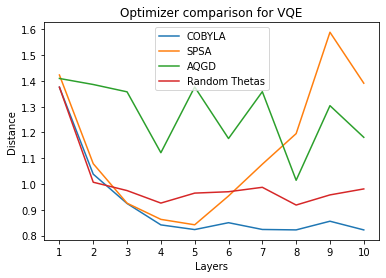

In [13]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
plt.plot(x_axis, cobyla_results, label="COBYLA")
plt.plot(x_axis, spsa_results, label="SPSA")
plt.plot(x_axis, aqgd_results, label="AQGD")
plt.plot(x_axis, random_results, label="Random Thetas")
plt.title('Optimizer comparison for VQE')
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')